In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append('/home/jcheung/PycharmProjects/')

import songanalysis.importmatfiles as imp
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

dir = '/opt/data/o93o75/'
datadir = dir+'analysis/data_structures/'
stream = open(dir+'config.yml')
config = yaml.load(stream)
stream = open(dir+'batch.yml')
batch = yaml.load(stream)

/home/jcheung/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/jcheung/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Are gap durations in repeats correlated with each other for every repeat rendition (at baseline)? 

In [2]:
#extract all repeat structures for bird into one dataframe
data = [imp.importrepstruct(datadir+x['structnm']+filenm+'.mat',condition) for x in config['repeats'] for condition
       in batch for filenm in batch[condition]]
df1,df2 = zip(*data)
df1 = pd.concat(df1)
df2 = pd.concat(df2)

/home/jcheung/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/jcheung/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


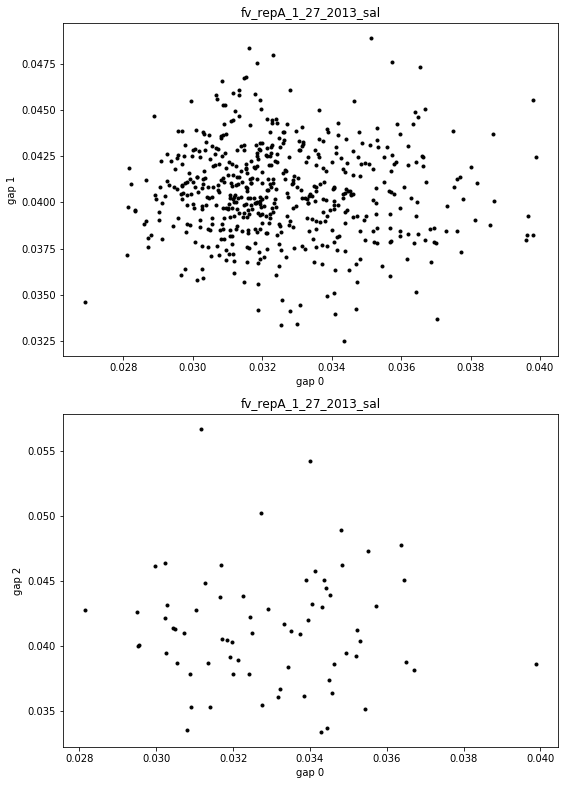

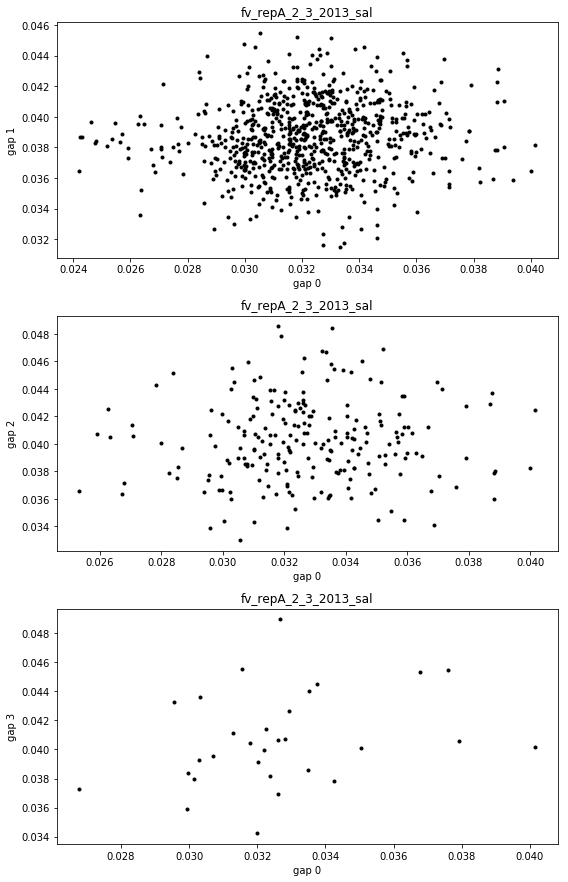

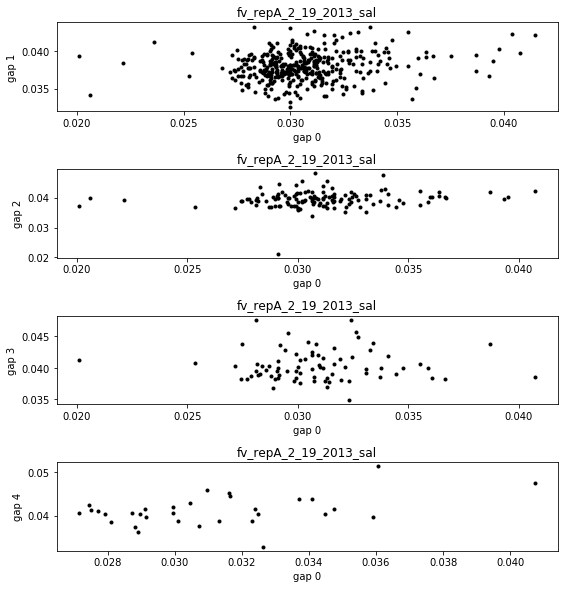

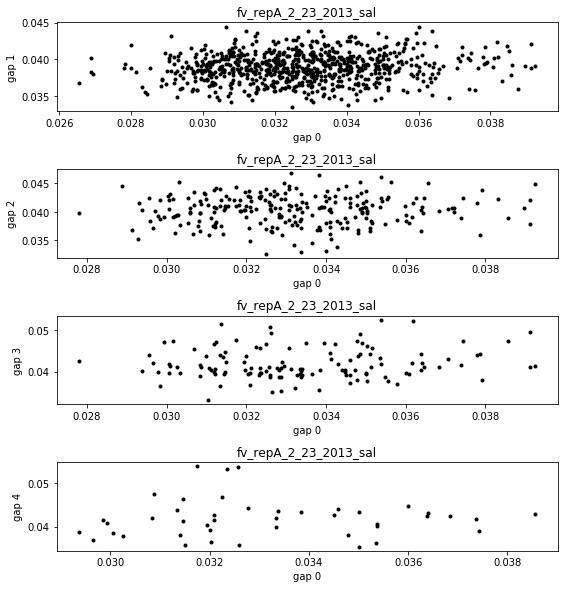

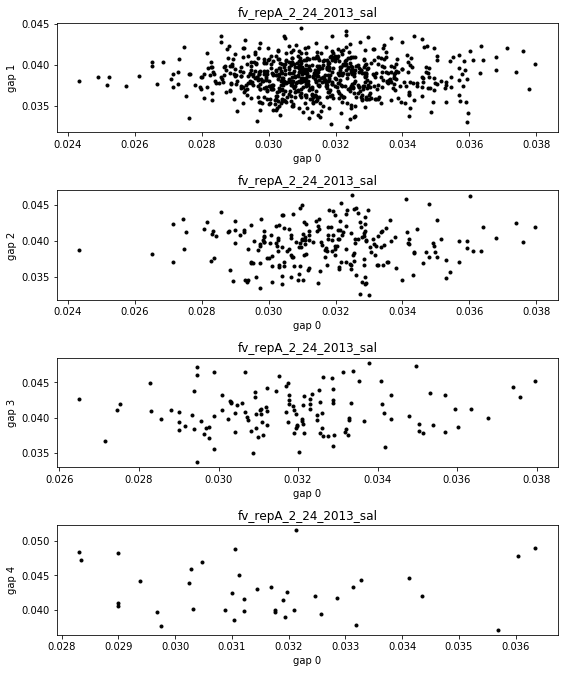

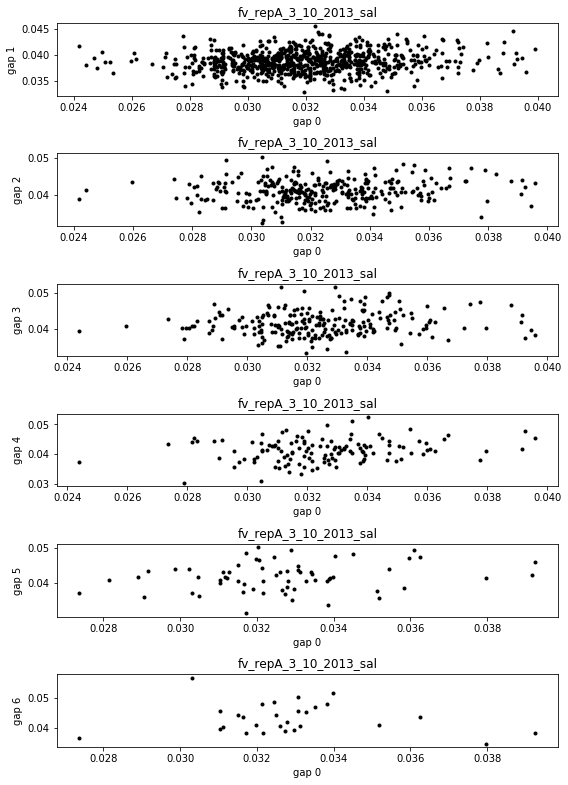

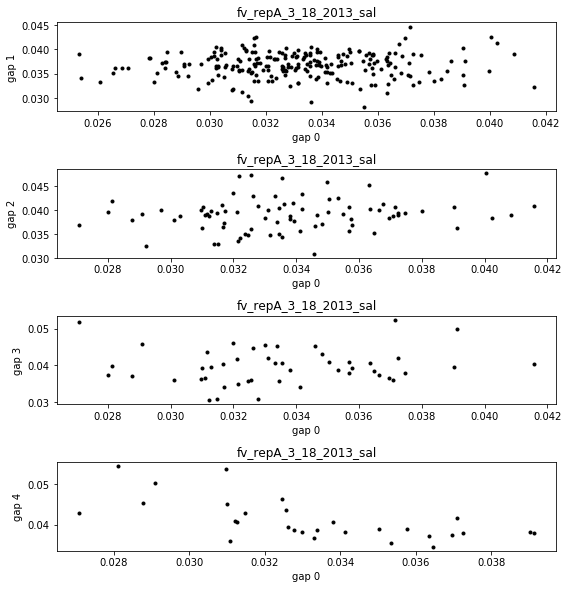

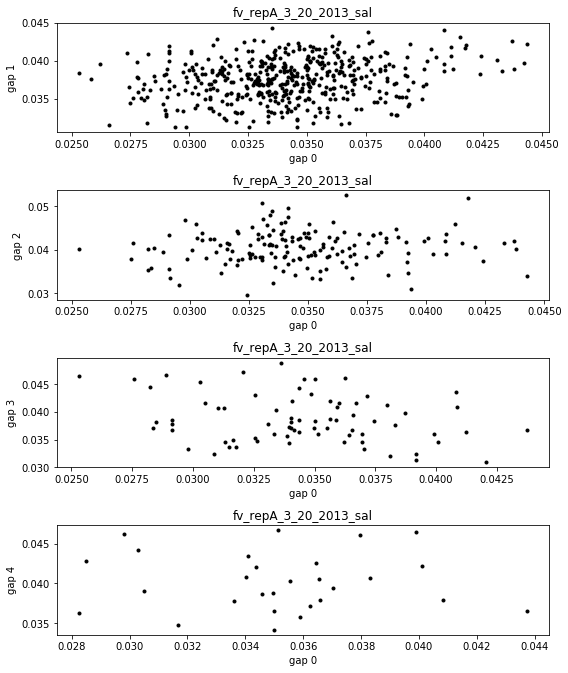

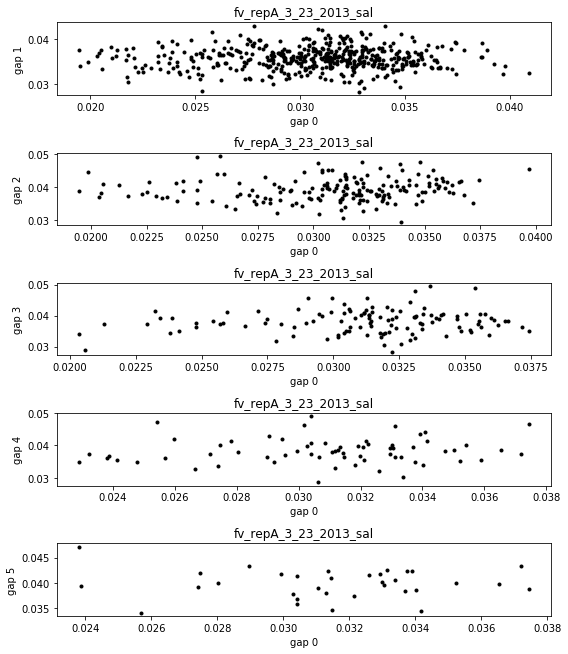

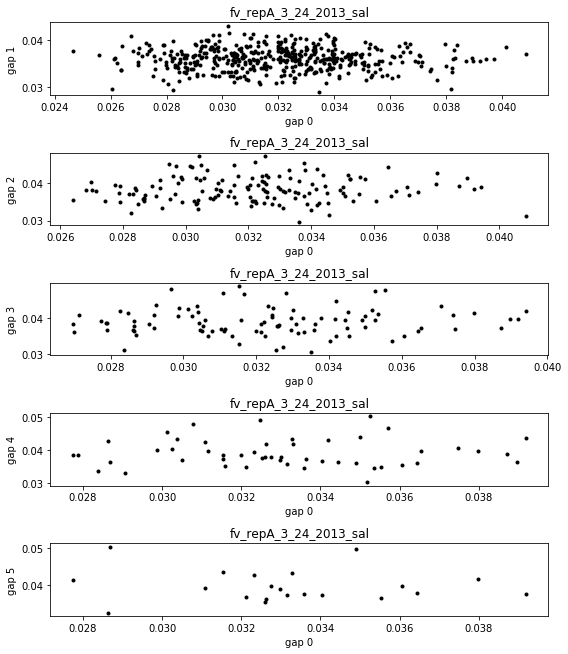

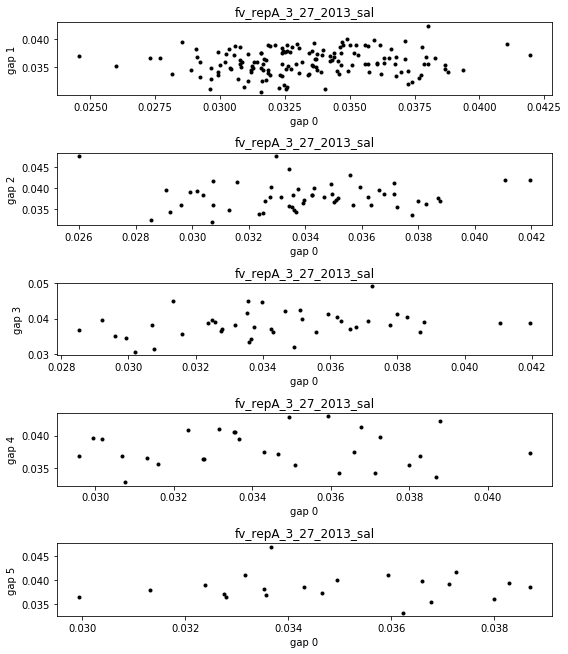

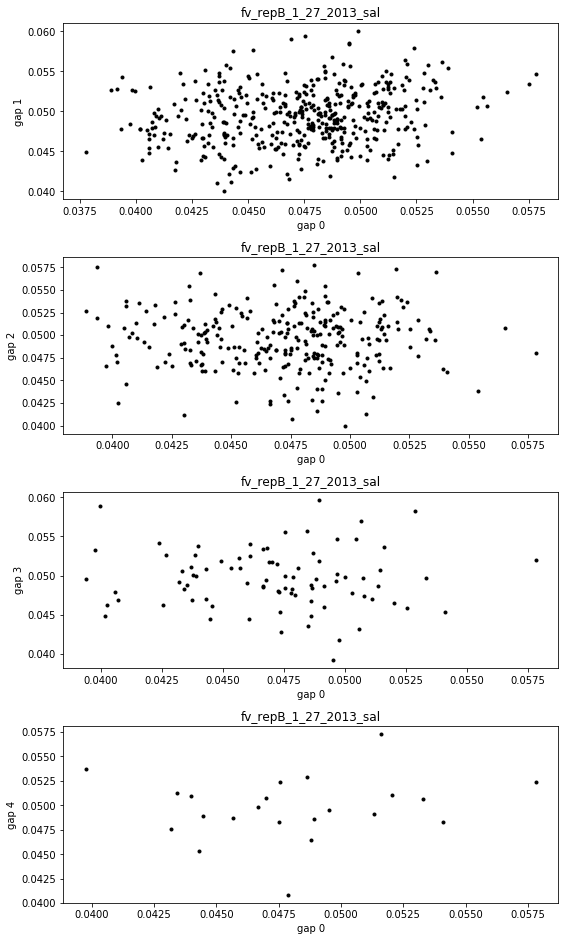

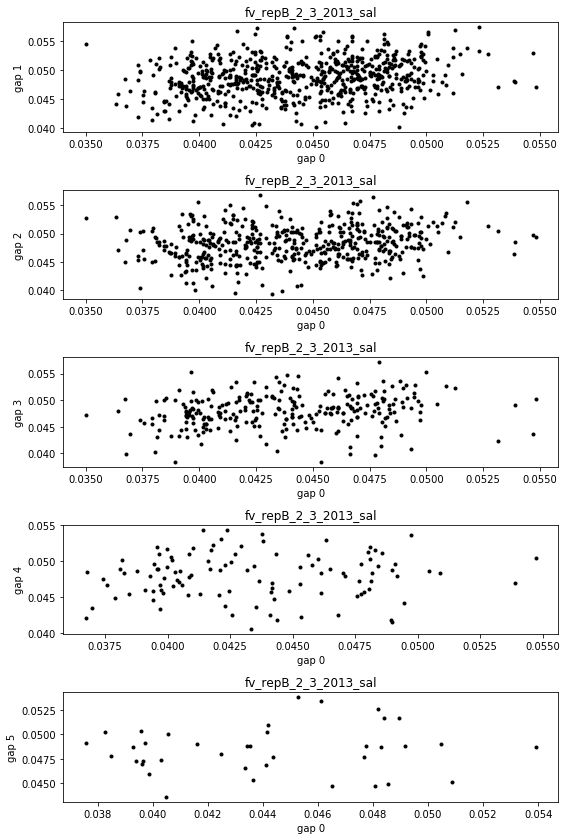

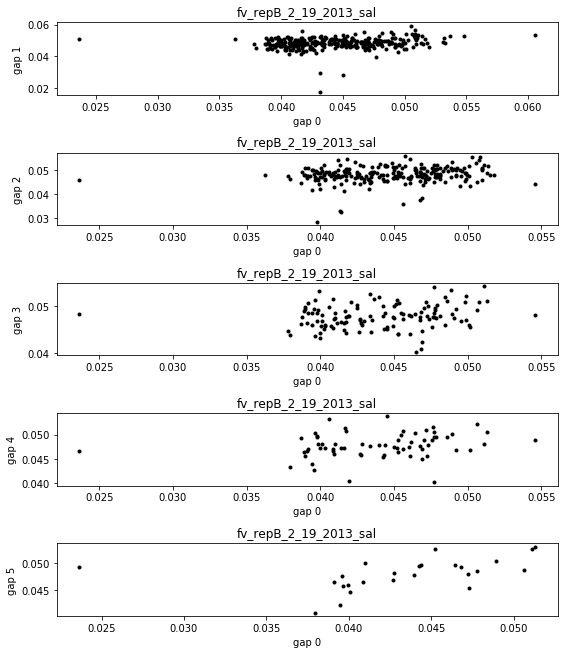

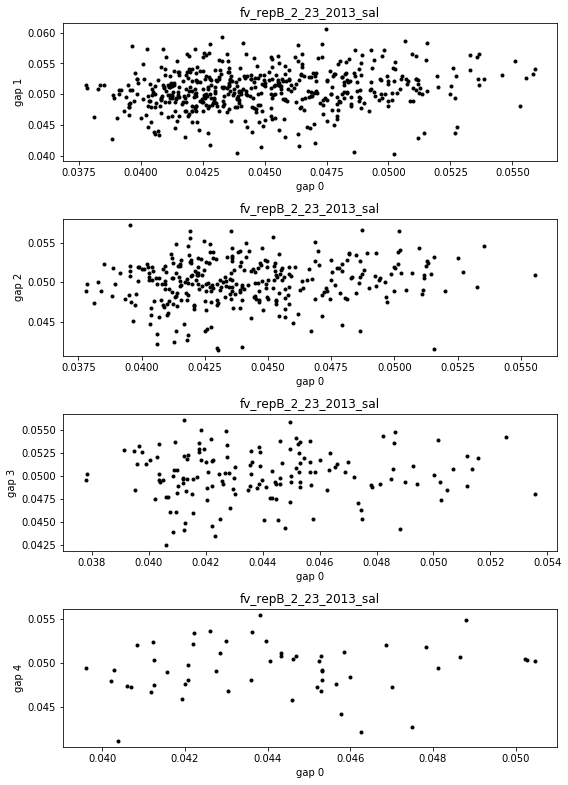

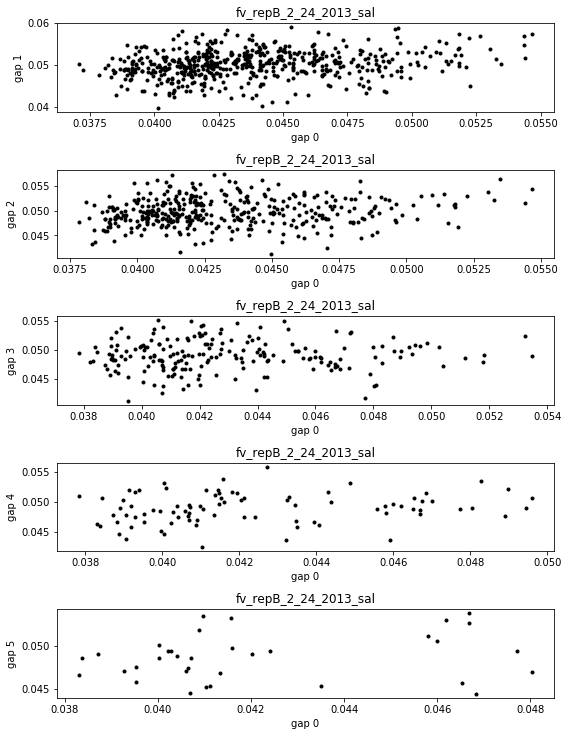

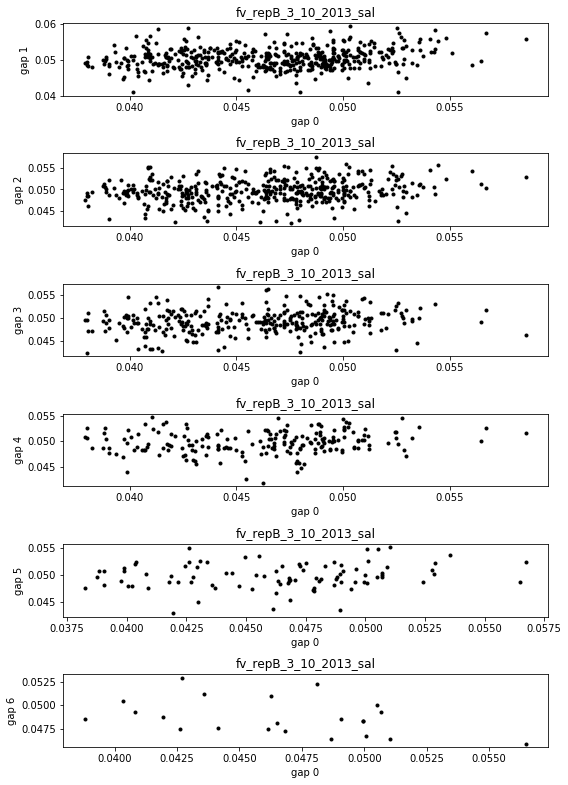

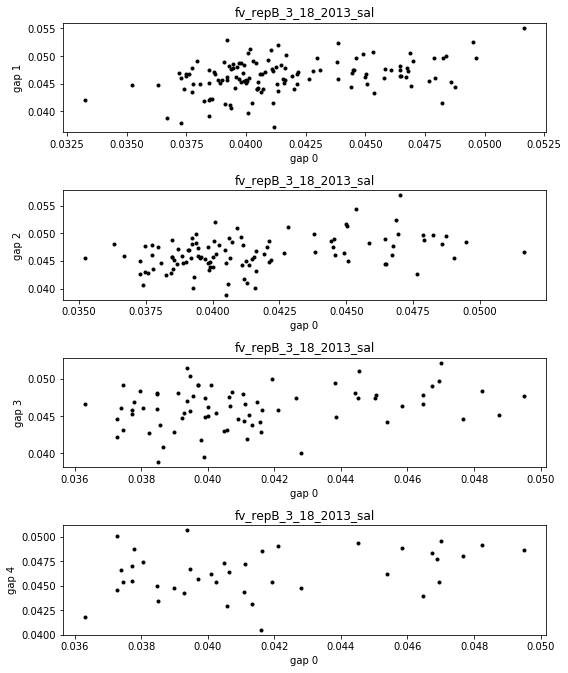

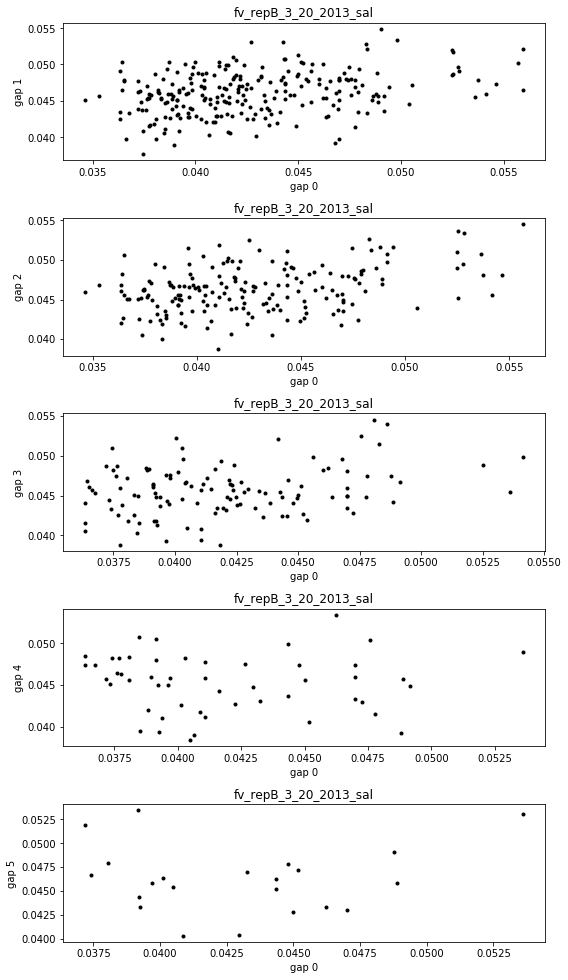

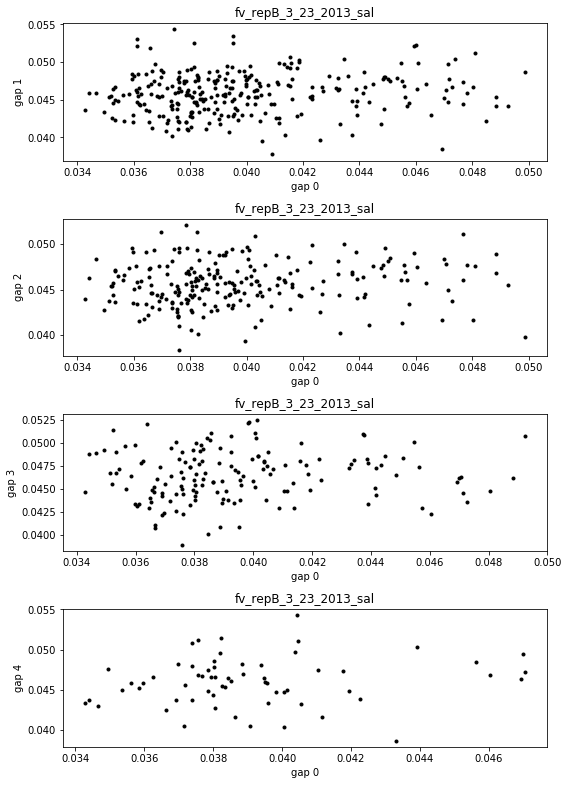

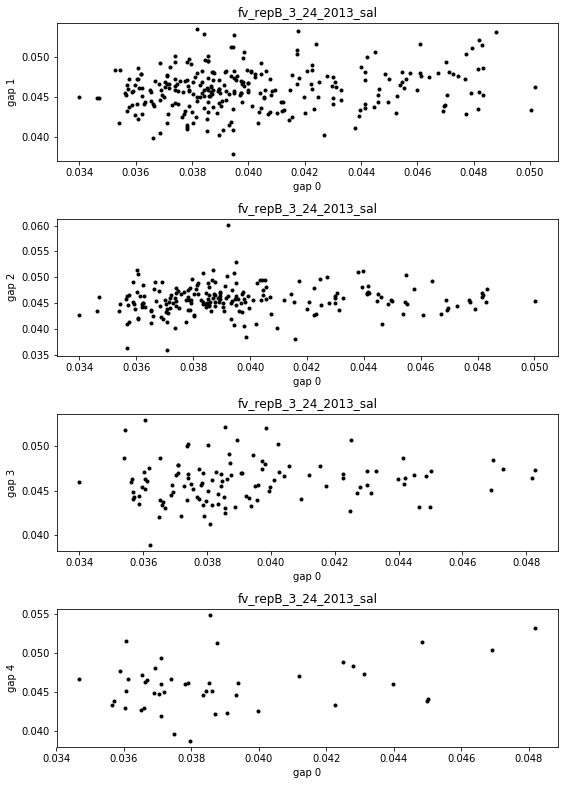

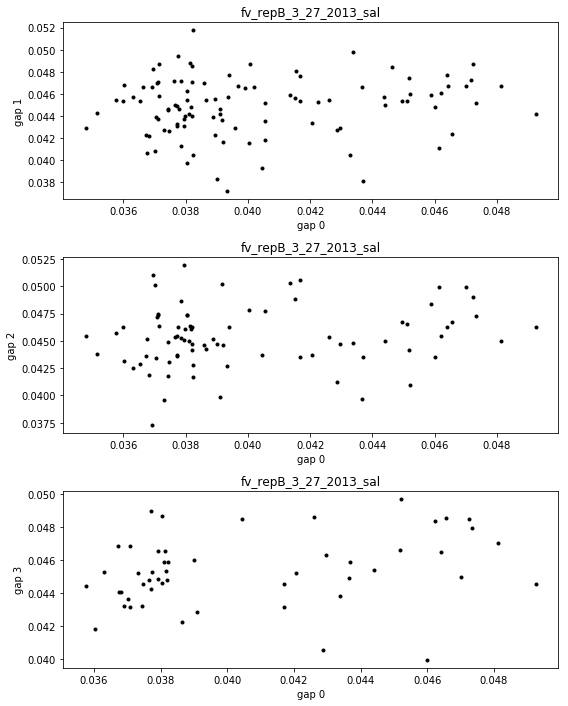

In [64]:
#for each repeat type, plot correlation between first gap duration and subsequent gaps
cnd = 'saline'
corrs = np.array([])
rsq = np.array([])
pvals = np.array([])
for x in config['repeats']:
    structnm = x['structnm']
    for trialnm in batch[cnd]:
        maxnumgaps = int(df1.query('name=="'+structnm+trialnm+'"').runlength.max()-1)
        x = df2.query('name=="'+structnm+trialnm+'"').xs(0,level='syllindex').syllgaps
        x = x[~((x-x.mean()).abs()>3*x.std())]
        fig = plt.figure(figsize=(8,16),tight_layout=True)
        for ind in range(1,maxnumgaps):
            y = df2.query('name=="'+structnm+trialnm+'"').xs(ind,level='syllindex').syllgaps
            y = y[~((y-y.mean()).abs()>3*y.std())]
            if len(y[pd.notnull(y)]) >= 20:
                plt.subplot(maxnumgaps-1,1,ind)
                z = pd.concat([x,y],axis=1)
                z.columns = ['0','1']
                plt.plot(z['0'],z['1'],'k.')
                plt.xlabel('gap 0')
                plt.ylabel('gap '+str(ind))
                plt.title(structnm+trialnm)
                plt.tight_layout
                
                zc = sm.add_constant(z)
                zc['0'] = (zc['0'] - zc['0'].mean())/zc['0'].std()
                model = sm.OLS(zc['1'],zc[['const','0']],missing='drop')
                results = model.fit()
                corrs = np.append(corrs,results.params['0'])
                pvals = np.append(pvals,results.pvalues['0'])
                rsq = np.append(rsq,results.rsquared_adj)
gapcorr = pd.DataFrame({'beta': corrs,'pvals':pvals,'rsq': rsq})   

In [65]:
#fraction of cases that are significantly correlated
sum(gapcorr.pvals <= 0.05)/gapcorr.shape[0]

0.3473684210526316

In [66]:
#average beta for significant cases
gapcorr.query('pvals<=0.05').beta.mean()

0.0005336659375733258

In [68]:
#average variability explained
gapcorr.rsq.mean()

0.022333861413831237

Duration of first gap in repeat is not consistently correlated with duration of subsequent gaps in repeat (only 35% of cases and average correlation is positive but very small for significant cases). The amount of variability in subsequent gaps that is explained by the duration of the first gap is 2%. 

### Does the duration of the first gap predict the repeat length?

In [86]:
#for each repeat type, plot correlation between first gap duration and repeat length
cnd = 'saline'
corrs = np.array([])
rsq = np.array([])
pvals = np.array([])
for x in config['repeats']:
    structnm = x['structnm']
    for trialnm in batch[cnd]:
        x = df2.query('name=="'+structnm+trialnm+'"').xs(0,level='syllindex').syllgaps
        x = x[~((x-x.mean()).abs()>3*x.std())]
        y = df1.query('name=="'+structnm+trialnm+'"').runlength
        z = pd.concat([x,y],axis=1)
        zc = sm.add_constant(z)
        zc['syllgaps'] = (zc['syllgaps'] - zc['syllgaps'].mean())/zc['syllgaps'].std()
        model = sm.OLS(zc['runlength'],zc[['const','syllgaps']],missing='drop')
        results = model.fit()
        corrs = np.append(corrs,results.params['syllgaps'])
        pvals = np.append(pvals,results.pvalues['syllgaps'])
        rsq = np.append(rsq,results.rsquared_adj)
gapreplencorr = pd.DataFrame({'beta': corrs,'pvals':pvals,'rsq': rsq})   

In [89]:
#fraction of cases that are significantly correlated
sum(gapreplencorr.pvals <= 0.05)/gapreplencorr.shape[0]

0.6818181818181818

In [92]:
#average correlation for significant cases
gapreplencorr.query('pvals<=0.05').beta.mean()

-0.0745318930391014

In [93]:
#average variability explained
gapreplencorr.rsq.mean()

0.01899231641153039

Most repeats are correlated with duration of first gap and average correlation is negative. However, only 2% of variability of explained.

### Change in gap duration for naspm vs saline (controlling for position in repeat)

In [100]:
#plot distribution of durations for each individual gap in saline vs naspm
drugtrials= [x for x in config['trials'] if x['condition']=='naspm']
salctrltrials = [x for x in config['trials'] if x['condition']=='saline']

for rep in config['repeats']:
    structnm = rep['structnm']
    for trialnm in drugtrials:
        maxnumgaps = df1.query('name=="'+structnm+trialnm['name']+'"').runlength.max()-1
        for ind in range(0,maxnumgaps):
            gapdur = df2.query('name=="'+structnm+trialnm['name']+'"').xs(ind,level='syllindex').syllgaps
            if gapdur[gapdur.notna()].shape[0] >= 10:
                replen = df1.query('name=="'+structnm+trialnm['name']+'"').runlength
                z = pd.concat([replen,gapdur],axis=1)
                fig = plt.figure(figsize=(8,16),tight_layout=True)
                
            



(array([  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          8.40336134,  25.21008403,  50.42016807,  58.82352941,
        168.06722689, 168.06722689, 201.68067227, 168.06722689,
         92.43697479,  25.21008403,   8.40336134,  25.21008403,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ]),
 array([0.02165625, 0.02265625, 0.02365625, 0.02465625, 0.02565625,
        0.02665625, 0.02765625, 0.02865625, 0.02965625, 0.03065625,
        0.03165625, 0.03265625, 0.03365625, 0.03465625, 0.03565625,
        0.03665625, 0.03765625, 0.03865625, 0.03965625, 0.04065625,
        0.04165625, 0.04265625, 0.04365625, 0.04465625, 0.04565625,
        0.04665625, 0.04765625, 0.04865625, 0.04965625, 0.05065625,
        0.05165625]),
 <a list of 30 Patch objects>)

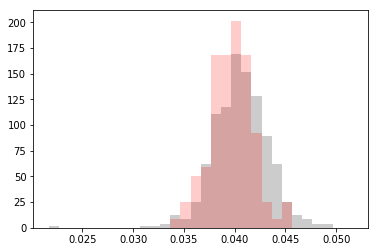

In [199]:
drugtrials= [x for x in config['trials'] if x['condition']=='naspm']
salctrltrials = [x for x in config['trials'] if x['condition']=='saline']
rep = config['repeats'][0]
trialnm = drugtrials[0]
dur_naspm = df2.query('name=="'+rep['structnm']+trialnm['name']+'"').xs(1,level='syllindex').syllgaps
dur_base = df2.query('name=="'+rep['structnm']+trialnm['baseline']+'"').xs(1,level='syllindex').syllgaps
mindur = min([dur_base.min(), dur_naspm.min()])
maxdur = max([dur_base.max(), dur_naspm.max()])
bins = np.arange(mindur,maxdur,0.001)
plt.hist(dur_base.dropna(),bins,density=True,facecolor='k',alpha=0.2)
plt.hist(dur_naspm.dropna(),bins,density=True,facecolor='r',alpha=0.2)

In [194]:
mindur = min([dur_base.min(), dur_naspm.min()])
maxdur = max([dur_base.max(), dur_naspm.max()])
bins = np.arange(mindur,maxdur,0.002)
bins

array([0.02165625, 0.02365625, 0.02565625, 0.02765625, 0.02965625,
       0.03165625, 0.03365625, 0.03565625, 0.03765625, 0.03965625,
       0.04165625, 0.04365625, 0.04565625, 0.04765625, 0.04965625,
       0.05165625])